# Перед началом работы:
Для запуска потребуется Python 3 с оболочкой Jupyter. Рекомендуется Анаконда: https://www.anaconda.com/products/individual

Документация по sentinelhub-py: https://sentinelhub-py.readthedocs.io/en/latest/

1. Установить модуль, команда в консоли Анаконды:
conda install -c conda-forge sentinelhub

где находится консоль -- зависит от операционной системы. Например, в MacOS запустить Anaconda Navigator и в нем Qt Console.

2. Зарегистрироваться https://services.sentinel-hub.com/oauth/subscription

3. Войти в https://www.sentinel-hub.com

4. Слева нажать Configuration utulity

5. New configuration -> выбрать Python script template из списка

6. Скопировать ID 

Теперь переходим в питон. Если не знакомы с Jupyter - чтобы запустить ячейку надо ее выделить и нажать Shift+Enter на клавиатуре, или кнопку Play мышкой

In [5]:
INSTANCE_ID = "" # Сюда вписываем свой ID

Черная магия и импорт библиотек. Взято из документации, чтобы можно было воспроизводить примеры оттуда: https://sentinelhub-py.readthedocs.io/en/latest/examples/processing_api_request.html#Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataSource, bbox_to_dimensions, DownloadRequest, WmsRequest, WcsRequest, CustomUrlParam

Задаем координаты:

In [3]:
vinogradovo_wgs84 = [38.51, 55.34, 38.70, 55.44]
vinogradovo_bbox =  BBox(bbox=vinogradovo_wgs84, crs=CRS.WGS84)

Составляем запрос и получаем картинки из него:

In [17]:
wcs_true_color_request = WcsRequest(layer='TRUE-COLOR-S2-L2A',
                                    bbox=vinogradovo_bbox,
                                    time=('2020-04-01','2020-04-15'),
                                    resx='10m', resy='10m',
                                    maxcc=0.3,
                                    instance_id=INSTANCE_ID)

wcs_true_color_img = wcs_true_color_request.get_data()

Узнаем, сколько изображений мы получили:

In [19]:
len(wcs_true_color_img)

2

На первом изображении видно, что выпал снег...

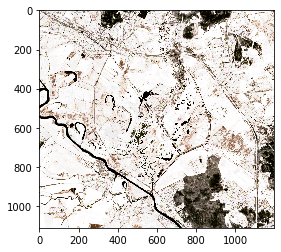

In [21]:
plt.imshow(wcs_true_color_img[0])

А на втором снега нет, но есть немного облаков

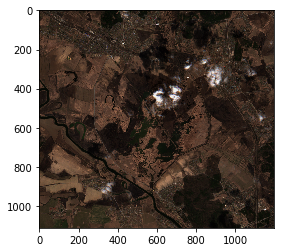

In [22]:
plt.imshow(wcs_true_color_img[1])

Узнаем, в какую дату было получено второе изображение:

In [27]:
dates = wcs_bands_request.get_dates()

In [61]:
dates[1].strftime('%Y-%m-%d')

'2020-04-09'

Теперь получим сырые данные по всем диапазонам Сентинеля (кроме одного, B10, с ним почему-то сейчас сне работает, может потом починят). Для этого составим внутренний текст для запроса, примерно как здесь: https://sentinelhub-py.readthedocs.io/en/latest/examples/processing_api_request.html#Example-1:-True-color-(PNG)-on-a-specific-date

In [23]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 12,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B11,
                sample.B12];
    }
"""

In [26]:
wcs_bands_request = WcsRequest(layer='TRUE-COLOR-S2-L2A',
                               bbox=vinogradovo_bbox,
                               time=('2020-04-01','2020-04-15'),
                               resx='20m', resy='20m',
                               maxcc=0.3,
                               image_format=MimeType.TIFF_d32f,
                               instance_id=INSTANCE_ID,
                               custom_url_params={CustomUrlParam.EVALSCRIPT : evalscript_all_bands})

data = wcs_bands_request.get_data()

Дальше используем только второе изображение, и извлекаем из него все диапазоны. data это многомерный массив. Каждая из переменных "b " содержит двумерный массив пикселей, то есть картинку. Кроме того, данные представлены в виде целых чисел от 0 до 10000, а нам нужны числа от 0 до 1.0.

In [57]:
b1,b2,b3,b4,b5,b6,b7,b8,b8a,b9,b11,b12 = data[1].transpose((2,0,1))/1e4

Вычисляем нормализованный индекс горимости

In [58]:
NBR = (b8-b12)/(b8+b12)

Рисуем картинку

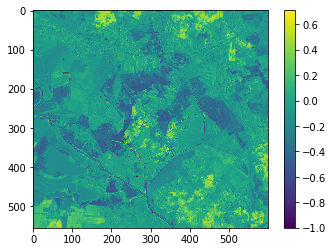

In [63]:
plt.imshow(NBR)
plt.colorbar()

Теперь мое предложение, как выделить гари:

In [64]:
burn = ((b8-b12)/(b8+b12) < -0.1) * (b4 < 0.07) * (b4 > 0.02)

Для отображения применим фильтр opening и также другую цветовую схему

In [65]:
from skimage.morphology import opening

(-0.5, 599.5, 555.5, -0.5)

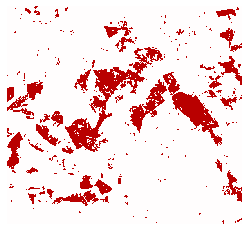

In [68]:
plt.imshow(opening(burn),cmap='seismic',vmin=-1.3,vmax=1.3)
plt.axis('off')